This code trains and evaluates a model using the 'Combined Images for Model' folder in SuperAnnotate.

# --------------------------------------------------------------------------------
# Bark Beetle Detection using Detectron2
# Developer: Helen Sandison
# Date: 15th October 2024
# Filename: bark_beetle_detection_v1.5
# Version: v1.5
# Kaggle Notebook
# --------------------------------------------------------------------------------
# Description:
# This notebook implements a Mask R-CNN model using Detectron2 to detect bark beetles from trap contents transferred to lab petri dishes. It performs dataset preparation, model training, and inference.
# Dataset structure is organised within Google Drive for easy access.
# --------------------------------------------------------------------------------
# Changelog:
# - v1.1: Remove redundant code
# Updated path definitions and usage
# Added in try-catch errors and logging
# Saved checkpoints every 500 iterations to Google Drive - and model checks and picks up from where it left off by checking Google Drive
# v1.2: Move notebook to Kaggle
# Still trying to save checkpoints to Google Drive 
# Kaggle GPU availability = 30 hours per week
# v1.5 larger dataset bark-beetle-dataset-v5
# --------------------------------------------------------------------------------
# Dataset Info
# Folders combined in SuperAnnotate:
# 14_8_to_16_08_F: all files except ER60_4_6_8.jpg [5 items]
# 21_08_to_02_09 F: all files [18 items]
# Composite images: all files [21 items]
# square dish - camera help by hand: all files [7 items]
# 51 image files in total
# Train=36; val=6; test=9
# Downloaded in COCO format, for instance segmentation
--------------------------------------------------------------------------------

In [1]:
# Install required libraries

# Install PyTorch for GPU
!pip install torch torchvision torchaudio

# Install Detectron2
!pip install -U torch torchvision
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install OpenCV and pycocotools for handling images and COCO format
!pip install opencv-python-headless
!pip install pycocotools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 75.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 61.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 28.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━

In [2]:
# Import Libraries

# Import libraries
import os
import json
import random
import numpy as np
import cv2
import logging
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from detectron2 import model_zoo
from detectron2.utils.logger import setup_logger
setup_logger()

# Setup a general logger for error handling
logging.basicConfig(filename="error_log.log", level=logging.ERROR,
                    format="%(asctime)s - %(levelname)s - %(message)s")


In [4]:
# Define important directories

# Define dataset directory
dataset_dir = Path("/kaggle/input/bark-beetle-dataset-v5/bark-beetle-dataset-v5")  # Update this path if needed

# Define directories for images and annotations
train_images_dir = dataset_dir / 'train' / 'images'
train_annotations_file = dataset_dir / 'train' / 'annotations' / "coco_annotations_train.json"

val_images_dir = dataset_dir / 'val' / 'images'
val_annotations_file = dataset_dir / 'val' / 'annotations' / "coco_annotations_val.json"

test_images_dir = dataset_dir / 'test' / 'images'
test_annotations_file = dataset_dir / 'test' / 'annotations' / "coco_annotations_test.json"

# Verify that the annotation files exist
for file in [train_annotations_file, val_annotations_file, test_annotations_file]:
    if not file.exists():
        logging.error(f"Annotation file not found: {file}")


In [5]:
import os

# Recursively print all files and directories in the dataset directory
for root, dirs, files in os.walk(dataset_dir):
    print(f"\nRoot: {root}")
    print(f"Directories: {dirs}")
    print(f"Files: {files}")





Root: /kaggle/input/bark-beetle-dataset-v5/bark-beetle-dataset-v5
Directories: ['val', 'test', 'train']
Files: []

Root: /kaggle/input/bark-beetle-dataset-v5/bark-beetle-dataset-v5/val
Directories: ['annotations', 'images']
Files: []

Root: /kaggle/input/bark-beetle-dataset-v5/bark-beetle-dataset-v5/val/annotations
Directories: []
Files: ['coco_annotations_val.json']

Root: /kaggle/input/bark-beetle-dataset-v5/bark-beetle-dataset-v5/val/images
Directories: []
Files: ['ER6_30_6_8.jpg', 'ER6_01_6_8.jpg', 'ER4_5_31_7.jpg', 'WE32 14.06 C.JPG', 'ER6_12_6_8.jpg', 'WE198_24_6.jpg', 'ER3_56_9_5.jpg', 'ER5_04_10_8.jpg', 'ER3_1_1_8.jpg', 'ER6_05_6_8.jpg', 'ER3_19_22_5.jpg', 'ER60_09_6_8.jpg', 'WE102 14.06 C.JPG', 'ER6_16_6_8.jpg', 'ER5_05_10_8.jpg', 'ER13_2_4_5.jpg', 'WE93 12.06 C.JPG', 'ER3_2_1_8.jpg', 'WE20 27.05.JPG', 'ER3_17_22_5.jpg', 'ER1_1_7_5 window no doors.jpg', 'ER4_6_31_7.jpg', 'ER1_9_7_5.jpg', 'WE203_26_2.jpg', 'ER10_1_8_5.jpg']

Root: /kaggle/input/bark-beetle-dataset-v5/bark-beet

In [6]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

# Function to unregister existing datasets
def unregister_datasets():
    # List of dataset names to unregister
    dataset_names = ["bark_beetle_train", "bark_beetle_val", "bark_beetle_test"]
    
    # Unregister datasets
    for name in dataset_names:
        # Check and remove dataset from DatasetCatalog
        if name in DatasetCatalog.list():  # Use list() to get registered dataset names
            DatasetCatalog.remove(name)
        # Check and remove dataset from MetadataCatalog
        if name in MetadataCatalog.list():  # Use list() to get registered dataset names
            MetadataCatalog.remove(name)

# Unregister the datasets
unregister_datasets()

# Register the datasets using the available annotation files
register_coco_instances("bark_beetle_train", {}, str(train_annotations_file), str(train_images_dir))
register_coco_instances("bark_beetle_val", {}, str(val_annotations_file), str(val_images_dir))
register_coco_instances("bark_beetle_test", {}, str(test_annotations_file), str(test_images_dir))

# Verify registration
train_metadata = MetadataCatalog.get("bark_beetle_train")
val_metadata = MetadataCatalog.get("bark_beetle_val")

print("Registered training dataset with", len(DatasetCatalog.get("bark_beetle_train")), "images.")
print("Registered validation dataset with", len(DatasetCatalog.get("bark_beetle_val")), "images.")



[10/17 08:26:21 d2.data.datasets.coco]: Loaded 121 images in COCO format from /kaggle/input/bark-beetle-dataset-v5/bark-beetle-dataset-v5/train/annotations/coco_annotations_train.json
Registered training dataset with 121 images.
[10/17 08:26:21 d2.data.datasets.coco]: Loaded 25 images in COCO format from /kaggle/input/bark-beetle-dataset-v5/bark-beetle-dataset-v5/val/annotations/coco_annotations_val.json
Registered validation dataset with 25 images.


In [ ]:
# visualise dataset

import random
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Visualize training images and annotations
def visualize_dataset(dataset_name, num_images=5):
    dataset_dicts = DatasetCatalog.get(dataset_name)
    metadata = MetadataCatalog.get(dataset_name)

    for d in random.sample(dataset_dicts, num_images):
        img = cv2.imread(d["file_name"])
        visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
        out = visualizer.draw_dataset_dict(d)
        plt.figure(figsize=(10, 10))
        plt.imshow(out.get_image()[:, :, ::-1])
        plt.axis('off')
        plt.show()

# Visualize training and validation datasets
visualize_dataset("bark_beetle_train")
visualize_dataset("bark_beetle_val")


In [9]:
# CLEAR THE OLD OUTPUT AND CHECKPOINTS DIRECTORY AND CREATE NEW ONES

import shutil
import os

# Clear the output directory if it exists
output_dir = './output'  # Adjust this if your output path is different
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)  # This will delete the entire directory and its contents
    print("Old output directory cleared.")

# Clear the checkpoints directory if it exists
checkpoints_dir = './checkpoints'  # Adjust this if your output path is different
if os.path.exists(checkpoints_dir):
    shutil.rmtree(checkpoints_dir)  # This will delete the entire directory and its contents
    print("Old checkpoints directory cleared.")

os.makedirs(output_dir, exist_ok=True)  # This creates the directory if it doesn't exist
os.makedirs(checkpoints_dir, exist_ok=True)  # This creates the directory if it doesn't exist

Old output directory cleared.
Old checkpoints directory cleared.


In [12]:
# Configure the model for training
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Initialize configuration
cfg = get_cfg()

# Load the Mask R-CNN model configuration
# 1st model: mask_rcnn_R_50_FPN_3x.yaml
# 2nd model: mask_rcnn_R_101_FPN_3x.yaml
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))

# Set the dataset names
cfg.DATASETS.TRAIN = ("bark_beetle_train",) # Training dataset
cfg.DATASETS.TEST = ("bark_beetle_val",)  # Validation dataset

# Data loader settings
cfg.DATALOADER.NUM_WORKERS = 2  # Number of workers for data loading

# Solver settings
cfg.SOLVER.IMS_PER_BATCH = 2  # Batch size
cfg.SOLVER.BASE_LR = 0.00025  # Learning rate
cfg.SOLVER.MAX_ITER = 3000  # Number of iterations

# Checkpoint settings
cfg.SOLVER.CHECKPOINT_PERIOD = 500  # Save checkpoint every 50 iterations

# Output directory
cfg.MODEL.OUTPUT_DIR = "./output"  # Directory to save model outputs

# Set the number of classes in the model (including the background)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(train_metadata.get("thing_classes", []))

# Create output directory
os.makedirs(cfg.MODEL.OUTPUT_DIR, exist_ok=True)

# Checkpoint directory for Kaggle
kaggle_checkpoint_dir = Path("./checkpoints")  # Local directory for saving checkpoints

# Create the local directory if it doesn't exist
os.makedirs(kaggle_checkpoint_dir, exist_ok=True)



In [ ]:
import shutil
import os
from detectron2.engine import DefaultTrainer
from pathlib import Path

# Define output and checkpoints directories
output_dir = "/kaggle/working/output"
checkpoint_dir = "/kaggle/working/checkpoints"

# Ensure output and checkpoints directories exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

# Print current working directory for debugging
print("Current working directory:", os.getcwd())

# Create a trainer object
trainer = DefaultTrainer(cfg)  # Initialise trainer
trainer.resume_or_load(resume=False)  # Do not resume from previous checkpoint

# Start training
trainer.train()

# Immediately copy the latest checkpoint to the output directory after training
def copy_latest_checkpoint():
    checkpoints = sorted(Path(checkpoint_dir).glob("*.pth"), key=os.path.getmtime)
    if checkpoints:
        latest_checkpoint = checkpoints[-1]
        shutil.copy(latest_checkpoint, output_dir)
        print(f"Latest checkpoint copied to output directory: {latest_checkpoint.name}")
    else:
        print("No checkpoints found to copy.")

# Call the function to copy the latest checkpoint
copy_latest_checkpoint()

# List contents of /kaggle/working/ to verify if directories and files exist
print("Contents of /kaggle/working/:")
print(os.listdir("/kaggle/working/"))




Current working directory: /kaggle/working
[10/17 08:29:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=

R-101.pkl: 179MB [00:00, 222MB/s]                             


[10/17 08:29:11 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[10/17 08:29:11 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105
[10/17 08:29:11 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/17 08:30:10 d2.utils.events]:  eta: 2:25:25  iter: 19  total_loss: 3.989  loss_cls: 1.445  loss_box_reg: 0.06513  loss_mask: 0.6935  loss_rpn_cls: 0.6909  loss_rpn_loc: 1.128    time: 2.8419  last_time: 2.9491  data_time: 2.1202  last_data_time: 2.1739   lr: 4.9953e-06  max_mem: 3917M
[10/17 08:31:15 d2.utils.events]:  eta: 2:19:34  iter: 39  total_loss: 2.998  loss_cls: 0.6624  loss_box_reg: 0.04845  loss_mask: 0.6935  loss_rpn_cls: 0.6815  loss_rpn_loc: 0.8663    time: 2.7064  last_time: 2.8065  data_time: 1.8742  last_data_time: 2.1129   lr: 9.9902e-06  max_mem: 3917M
[10/17 08:32:10 d2.utils.events]:  eta: 2:17:59  iter: 59  total_loss: 2.586  loss_cls: 0.4311  loss_box_reg: 0.03766  loss_mask: 0.6905  loss_rpn_cls: 0.6766  loss_rpn_loc: 0.7803    time: 2.7242  last_time: 3.5282  data_time: 2.0546  last_data_time: 2.8133   lr: 1.4985e-05  max_mem: 4050M
[10/17 08:33:03 d2.utils.events]:  eta: 2:16:33  iter: 79  total_loss: 2.751  loss_cls: 0.4768  loss_box_reg: 0.04628  loss_ma

In [11]:
import shutil

# Create a zip file of the output directory
shutil.make_archive('/kaggle/working/model_output', 'zip', './output')



KeyboardInterrupt



In [ ]:
import os

# Create a directory for the model
os.makedirs('/kaggle/working/model_directory', exist_ok=True)

# Move the model_final.pth file to the new directory
shutil.copy('./output/model_final.pth', '/kaggle/working/model_directory/model_final.pth')

# Initialize the Kaggle dataset
!kaggle datasets init -p /kaggle/working/model_directory

# Create the Kaggle dataset
!kaggle datasets create -p /kaggle/working/model_directory --dir-mode zip



In [12]:
# Check for GPU availability
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("GPU is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available.")


GPU is available!
GPU Name: Tesla T4


In [13]:
import multiprocessing
from detectron2.evaluation import COCOEvaluator
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import inference_on_dataset

# Set the start method for multiprocessing to avoid potential deadlocks
multiprocessing.set_start_method('spawn', force=True)

# Create COCO Evaluator for validation set
evaluator = COCOEvaluator(
    dataset_name="bark_beetle_val",
    output_dir="./output/",
    use_fast_impl=False  # Set to True to use a faster implementation if supported
)

# Build the validation data loader
val_loader = build_detection_test_loader(cfg, "bark_beetle_val")

# Evaluate the model on the validation set
results = inference_on_dataset(trainer.model, val_loader, evaluator)
print("Evaluation results on validation set:", results)





[10/15 14:52:25 d2.data.datasets.coco]: Loaded 25 images in COCO format from /kaggle/input/bark-beetle-dataset-v5/bark-beetle-dataset-v5/val/annotations/coco_annotations_val.json
[10/15 14:52:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/15 14:52:25 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/15 14:52:25 d2.data.common]: Serializing 25 elements to byte tensors and concatenating them all ...
[10/15 14:52:25 d2.data.common]: Serialized dataset takes 0.45 MiB
[10/15 14:52:25 d2.evaluation.evaluator]: Start inference on 25 batches
[10/15 14:52:56 d2.utils.memory]: Attempting to copy inputs of <function paste_masks_in_image at 0x7d9e146e6d40> to CPU due to CUDA OOM
[10/15 14:53:41 d2.utils.memory]: Attempting to copy inputs of <function paste_masks_in_image at 0x7d9e146e6d40> to CPU due to CUDA OOM
[10/15 14

In [14]:
# Import necessary libraries
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer

# Initialize configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Specify the correct number of classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # Change this to your actual number of classes

# Load the weights from the trained model
cfg.MODEL.WEIGHTS = './output/model_final.pth'  # Adjust the path if needed
# If using Google Drive, uncomment the next line and comment the line above
# cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/BarkBeetleDetectionModel/model/model_final.pth'

# Set the threshold for predictions
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set the threshold for this model

# Force the code to run on CPU
cfg.MODEL.DEVICE = "cuda"  # cpu - or change this to "cuda" if you have GPU support

# Create predictor
predictor = DefaultPredictor(cfg)

# Create checkpointer and load weights (without weights_only)
checkpointer = DetectionCheckpointer(predictor.model)
checkpointer.load(cfg.MODEL.WEIGHTS)  # Removed weights_only parameter


[10/15 15:01:01 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/opt/conda/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[10/15 15:01:01 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


{'trainer': {'iteration': 2999,
  'hooks': {'LRScheduler': {'base_lrs': [0.00025], 'last_epoch': 3000}},
  '_trainer': {'iteration': 2999,
   'optimizer': {'state': {0: {'momentum_buffer': tensor([[[[-1.5844e-03]],
      
               [[-1.1269e-04]],
      
               [[-2.6180e-03]],
      
               ...,
      
               [[-6.2692e-03]],
      
               [[ 3.0028e-04]],
      
               [[-1.5790e-03]]],
      
      
              [[[-1.0438e-03]],
      
               [[ 1.6149e-03]],
      
               [[ 3.1882e-03]],
      
               ...,
      
               [[ 4.2804e-03]],
      
               [[ 5.1481e-03]],
      
               [[ 3.5058e-03]]],
      
      
              [[[ 5.6972e-03]],
      
               [[ 9.6666e-04]],
      
               [[ 6.0010e-03]],
      
               ...,
      
               [[ 7.3053e-03]],
      
               [[ 5.0098e-03]],
      
               [[ 2.9572e-03]]],
      
      
          

Listing images in the folder:
['ER3_38_22_5.jpg', 'WE198_24_6.jpg', 'ER3_35_22_5.jpg', 'ER3_1_23_5.jpg', 'ER9_15_13_8.jpg', 'ER3_4_22_5.jpg', 'ER5_01_10_8.jpg', 'WE188_26_6.jpg', 'WE187_26_6.jpg']
Loaded image: /kaggle/input/bark-beetle-dataset-v2/bark-beetle-dataset-v2/test/images/ER3_38_22_5.jpg
Predictions: {'instances': Instances(num_instances=25, image_height=3741, image_width=10289, fields=[pred_boxes: Boxes(tensor([[4902.8076, 1109.8026, 5366.9121, 1519.8822],
        [2325.9526, 1524.9592, 2416.6919, 1624.3783],
        [7343.2261, 2910.0212, 7775.6694, 3032.8218],
        [3908.3909, 1780.5298, 4103.9492, 2002.6564],
        [7466.0410, 2721.1716, 7620.2358, 2888.5645],
        [3867.7117, 2383.7283, 4145.7563, 2558.7007],
        [6273.0552, 1397.2329, 6482.8428, 1551.8669],
        [4098.0269, 1202.7048, 4432.0952, 1613.4683],
        [4491.9087, 2257.4751, 4640.6816, 2436.8152],
        [6057.9785,  829.0132, 6511.8652, 1201.2750],
        [7407.0747, 1433.0713, 7696.1069, 

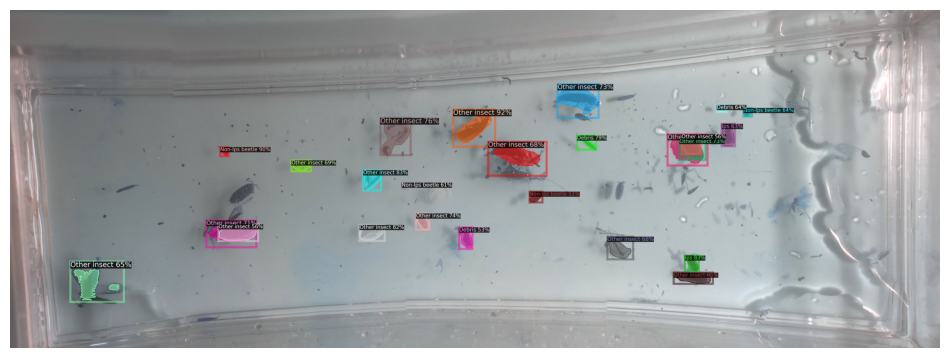

Loaded image: /kaggle/input/bark-beetle-dataset-v2/bark-beetle-dataset-v2/test/images/WE198_24_6.jpg
Predictions: {'instances': Instances(num_instances=34, image_height=4914, image_width=10091, fields=[pred_boxes: Boxes(tensor([[4013.0010,  948.9468, 4171.8296, 1132.8518],
        [6627.2153, 4336.3799, 6753.7466, 4585.7422],
        [7156.0264, 1627.8586, 7811.7368, 2162.9507],
        [1706.3160, 2098.9226, 1850.8402, 2258.3088],
        [4574.0752, 1588.1100, 4952.1997, 2135.4749],
        [3878.9575, 1282.1348, 4240.1123, 1429.8464],
        [4085.1523, 3831.7007, 4257.3110, 3959.9241],
        [5332.9927, 4485.3638, 5463.8521, 4658.7827],
        [8700.4443, 2226.1372, 8889.0762, 2406.4363],
        [6663.3516, 2259.9785, 6850.1118, 2411.0706],
        [1660.8314, 1649.2283, 1770.3607, 1737.5907],
        [1461.8828, 4393.9048, 1813.4946, 4587.1323],
        [4348.9277, 3619.7993, 4817.6753, 3988.8091],
        [5975.1035, 4108.1504, 6152.8032, 4261.6538],
        [7398.2856, 1194

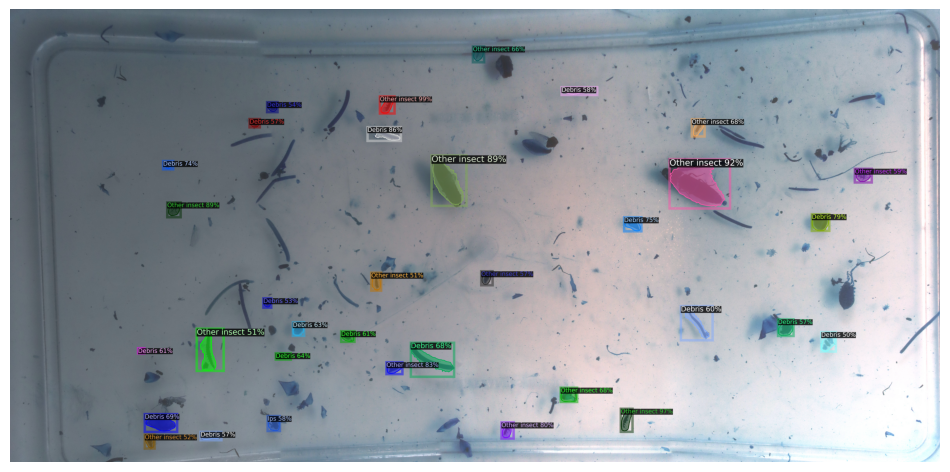

Loaded image: /kaggle/input/bark-beetle-dataset-v2/bark-beetle-dataset-v2/test/images/ER3_35_22_5.jpg
Predictions: {'instances': Instances(num_instances=25, image_height=4909, image_width=10295, fields=[pred_boxes: Boxes(tensor([[1.8178e+03, 2.8244e+00, 2.1957e+03, 5.5646e+02],
        [9.3375e+03, 2.9562e+03, 9.5444e+03, 3.0807e+03],
        [6.3391e+03, 3.2576e+03, 6.4642e+03, 3.5320e+03],
        [7.0374e+03, 8.7501e+02, 7.1694e+03, 1.1607e+03],
        [6.9066e+03, 2.9340e+03, 7.0439e+03, 3.1113e+03],
        [9.0633e+02, 4.3359e+03, 1.0012e+03, 4.4277e+03],
        [2.4408e+03, 3.8999e+03, 2.8301e+03, 4.2675e+03],
        [7.6996e+03, 1.4551e+03, 7.9332e+03, 1.6506e+03],
        [8.7463e+03, 1.0197e+03, 8.8338e+03, 1.1372e+03],
        [4.5714e+03, 2.8175e+03, 4.6535e+03, 2.9599e+03],
        [3.1660e+03, 3.3496e+03, 3.3181e+03, 3.4749e+03],
        [1.3893e+03, 1.1061e+03, 1.5619e+03, 1.2889e+03],
        [1.4512e+02, 1.7646e+03, 5.4178e+02, 2.0673e+03],
        [6.8793e+03, 3.66

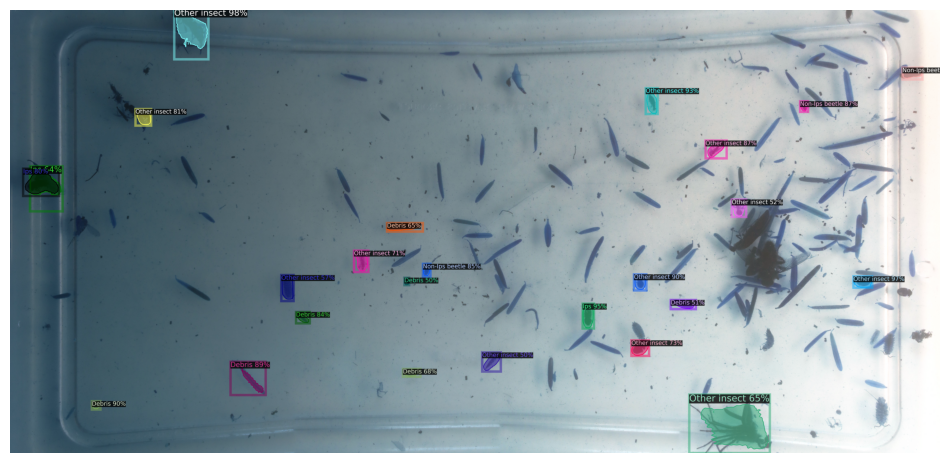

Loaded image: /kaggle/input/bark-beetle-dataset-v2/bark-beetle-dataset-v2/test/images/ER3_1_23_5.jpg
Predictions: {'instances': Instances(num_instances=32, image_height=5332, image_width=11351, fields=[pred_boxes: Boxes(tensor([[8917.0928, 4992.8086, 9132.3223, 5172.7153],
        [2900.6287, 3265.1848, 3572.1550, 3997.0503],
        [9271.6240, 3741.6682, 9404.4209, 3936.8872],
        [6739.7090, 4835.1807, 6959.3789, 5058.6880],
        [8731.6279, 1726.2311, 9163.2637, 2631.7859],
        [9107.9160, 2955.5730, 9899.6318, 3384.1873],
        [1879.8821, 2070.2019, 2093.9434, 2230.8906],
        [3738.7671, 4933.0430, 3890.2786, 5126.6899],
        [5603.7202, 1389.6072, 5893.6558, 1652.3888],
        [5106.2759, 1663.6716, 5270.3599, 1855.2057],
        [2116.7771, 3251.9531, 2317.7515, 3469.0488],
        [6476.8975, 2840.8159, 6774.3618, 2995.5889],
        [2209.2212, 1388.4135, 2450.5010, 1557.2450],
        [1932.0067, 5113.3477, 2152.0098, 5326.8857],
        [7619.5117, 4906

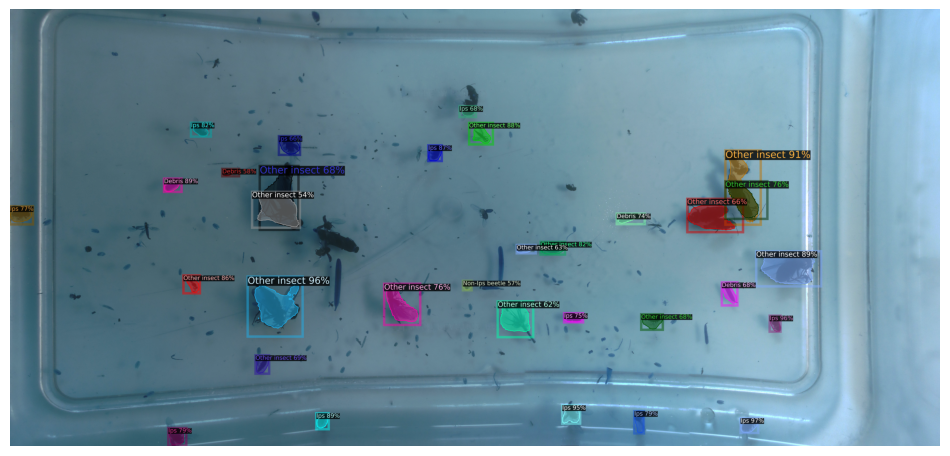

Loaded image: /kaggle/input/bark-beetle-dataset-v2/bark-beetle-dataset-v2/test/images/ER9_15_13_8.jpg
Predictions: {'instances': Instances(num_instances=23, image_height=4878, image_width=12973, fields=[pred_boxes: Boxes(tensor([[ 6186.5664,  2664.7195,  6427.7217,  3046.5715],
        [ 1016.6719,   870.3785,  1415.1239,  1215.2714],
        [  833.2409,  2187.2974,  1012.2791,  2494.6060],
        [ 4333.0708,  1831.0280,  4506.4487,  2051.5159],
        [ 2714.2678,   975.6571,  3152.8125,  1225.4376],
        [ 6910.3154,  3265.7568,  7272.5923,  3674.3320],
        [ 4731.9575,  2817.4521,  4926.8149,  3024.6123],
        [ 8904.9238,  1435.3491,  9121.0557,  1677.1057],
        [11471.1250,  2411.6738, 11575.3105,  2539.0974],
        [ 4247.8330,  3150.5364,  4339.2710,  3301.2024],
        [ 7405.8950,  2340.5552,  7883.3696,  2725.2285],
        [  680.5817,  2153.8079,  1056.8689,  2522.3608],
        [ 5968.4106,  3563.1326,  6113.9619,  3719.8928],
        [ 8587.0459,  380

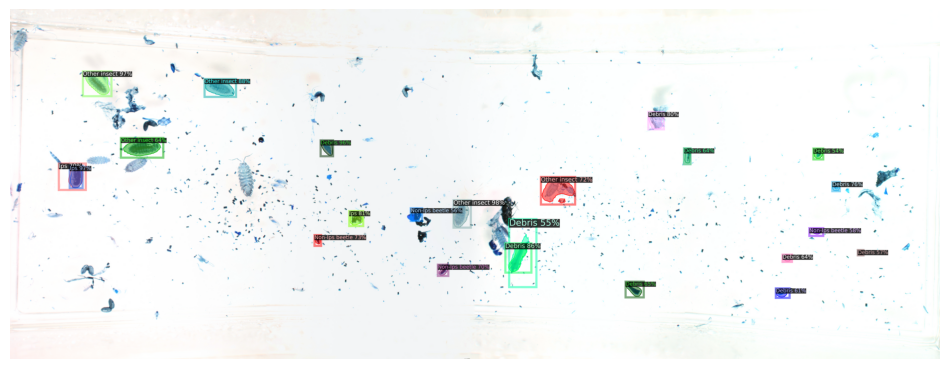

Loaded image: /kaggle/input/bark-beetle-dataset-v2/bark-beetle-dataset-v2/test/images/ER3_4_22_5.jpg
Predictions: {'instances': Instances(num_instances=18, image_height=4964, image_width=10320, fields=[pred_boxes: Boxes(tensor([[ 740.4701,  587.5994,  930.3357,  711.5589],
        [3884.3704, 1792.9152, 3984.2888, 1909.1185],
        [2667.9570, 4182.0254, 2922.9404, 4350.1729],
        [7869.1831,  302.5265, 8432.2158,  877.8502],
        [7249.2217, 3961.5791, 7483.3794, 4094.4033],
        [4774.8301, 3476.9299, 4981.4609, 3701.3684],
        [6366.6953, 1577.4729, 6566.3213, 1790.1364],
        [4047.2886,  466.1806, 4220.6636,  695.7952],
        [3834.8425, 1938.1396, 4028.0356, 2042.4436],
        [ 382.3559, 1770.8337,  770.2510, 2532.1497],
        [2671.9106, 1822.5975, 2831.4553, 1900.0449],
        [7174.8306, 2191.4714, 7318.3916, 2418.0186],
        [4231.7681, 2963.6965, 4652.8784, 3466.2979],
        [8376.3594, 1809.6290, 8661.7480, 2215.5757],
        [3152.3933, 3321

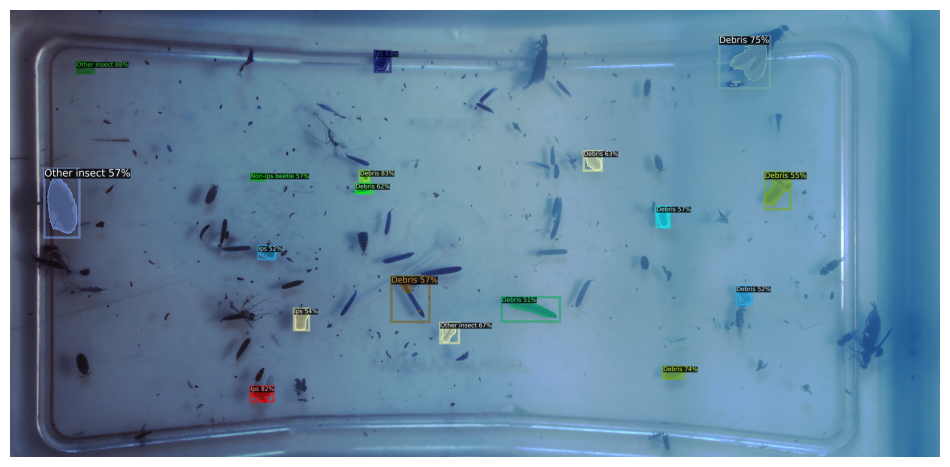

Loaded image: /kaggle/input/bark-beetle-dataset-v2/bark-beetle-dataset-v2/test/images/ER5_01_10_8.jpg
Predictions: {'instances': Instances(num_instances=55, image_height=4939, image_width=12732, fields=[pred_boxes: Boxes(tensor([[ 1699.9978,  3287.6448,  1878.3503,  3485.2129],
        [10899.8428,  2180.0784, 11074.1367,  2431.9011],
        [10633.3369,  1852.1299, 10771.2373,  2089.5884],
        [ 2227.4634,  2738.1638,  2411.1621,  2914.7212],
        [ 4172.9238,  3640.3818,  4336.1826,  3759.4749],
        [ 2295.8882,  3851.1863,  2480.1975,  3975.4126],
        [ 4115.2798,  1736.8943,  4341.5703,  1972.8676],
        [ 7685.0308,  2818.3201,  7929.4478,  2973.7219],
        [ 1471.9462,  1259.7620,  1633.8688,  1414.0386],
        [10719.1816,  2560.2754, 10955.0811,  2785.6394],
        [ 3160.5134,  2541.6548,  3515.9375,  2955.0237],
        [ 2327.4285,  3215.7173,  2450.8589,  3318.3682],
        [ 2554.8809,  2713.5637,  2664.0303,  2889.2668],
        [ 3275.3438,  411

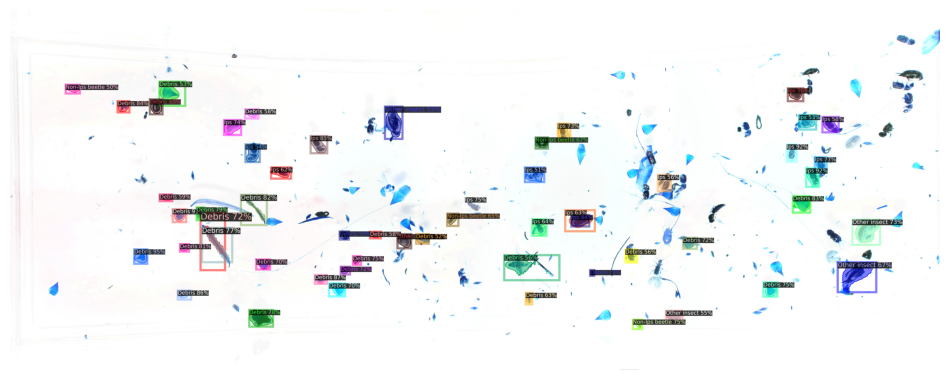

Loaded image: /kaggle/input/bark-beetle-dataset-v2/bark-beetle-dataset-v2/test/images/WE188_26_6.jpg
Predictions: {'instances': Instances(num_instances=14, image_height=4893, image_width=10488, fields=[pred_boxes: Boxes(tensor([[2110.9807, 2871.3838, 2205.0977, 2943.4783],
        [5328.3745, 4194.4302, 5377.2593, 4245.7051],
        [5377.3560, 3080.0144, 5434.3374, 3133.8037],
        [3451.9729, 2022.4082, 3537.7412, 2126.1658],
        [1607.8978, 3390.0205, 1672.9678, 3452.2822],
        [1801.1102, 3095.8179, 1909.4789, 3166.8354],
        [2740.3391, 2624.3694, 2801.4541, 2681.9751],
        [8882.2881,  603.2226, 9114.9990,  803.6323],
        [5929.6787, 3564.9275, 5968.7134, 3595.7441],
        [2477.8501, 3292.3184, 2537.6301, 3354.2791],
        [3202.4941, 3685.4358, 3259.8621, 3747.0000],
        [2541.9717, 2816.3721, 2635.2693, 2907.9763],
        [5454.2788, 3439.8784, 5489.4609, 3491.6802],
        [5391.2031, 1624.9817, 5432.8560, 1679.5074]], device='cuda:0')), scor

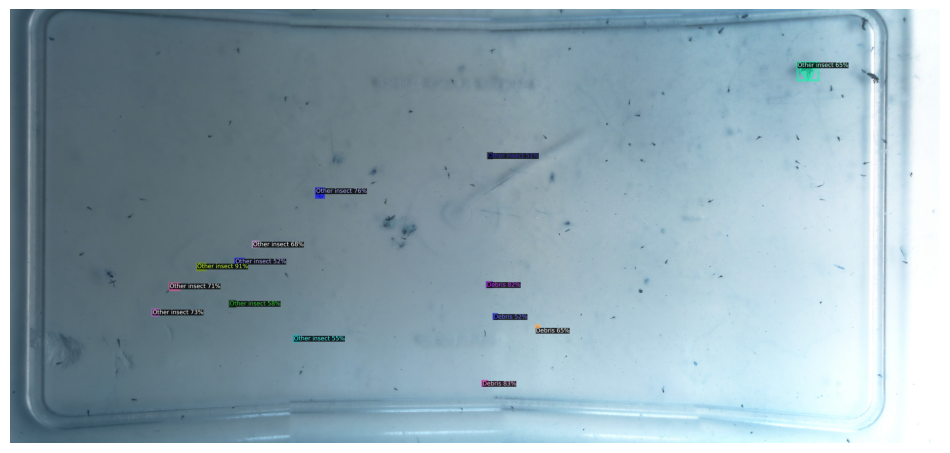

Loaded image: /kaggle/input/bark-beetle-dataset-v2/bark-beetle-dataset-v2/test/images/WE187_26_6.jpg
Predictions: {'instances': Instances(num_instances=7, image_height=4590, image_width=9708, fields=[pred_boxes: Boxes(tensor([[7249.5811,  760.2123, 7451.4624,  980.0455],
        [7803.1636, 2370.8999, 8219.3711, 2755.2163],
        [1804.6306, 1409.8960, 2066.2063, 1613.8877],
        [3365.3647, 2003.0736, 3483.2563, 2241.9583],
        [4993.0718, 1559.0186, 5361.6650, 1805.8395],
        [7240.4302, 1617.9352, 7960.8491, 2985.9426],
        [7290.4448, 1807.5596, 8188.0171, 2653.6064]], device='cuda:0')), scores: tensor([0.7971, 0.7911, 0.7441, 0.7418, 0.5990, 0.5932, 0.5247],
       device='cuda:0'), pred_classes: tensor([2, 3, 3, 3, 3, 2, 2], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, Fals

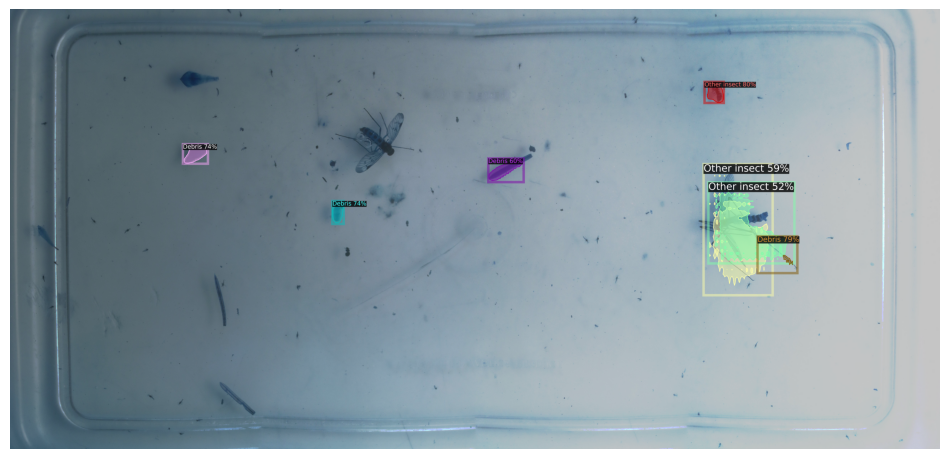

In [15]:
import cv2 
import os 
import matplotlib.pyplot as plt 
from detectron2.utils.visualizer import Visualizer 
from detectron2.data import MetadataCatalog

# Correct image folder path for Kaggle
image_folder_path = "/kaggle/input/bark-beetle-dataset-v5/bark-beetle-dataset-v5/test/images/" 
predictions_folder_path = "./predictions/"  # Local predictions folder within the working directory

# Create predictions folder if it doesn't exist
os.makedirs(predictions_folder_path, exist_ok=True)

# List images in the folder to ensure it contains the expected files
print("Listing images in the folder:")
image_files = os.listdir(image_folder_path)  # List images in the folder
print(image_files)

# Loop through each image in the directory
for image_file in image_files:
    sample_image_path = os.path.join(image_folder_path, image_file)  # Get the full image path
    image = cv2.imread(sample_image_path)

    # Check if the image was loaded correctly
    if image is None: 
        print(f"Error loading the image: {sample_image_path}")
        continue  # Skip to the next image if there is an error

    print(f"Loaded image: {sample_image_path}")  # Print loaded image path

    # Make predictions
    outputs = predictor(image)

    # Check predictions
    print("Predictions:", outputs)  # Inspect the outputs
    if outputs["instances"].has("pred_classes"):
        print("Number of instances predicted:", len(outputs["instances"]))
    else:
        print("No instances predicted.")

    # Visualize the predictions
    metadata = MetadataCatalog.get("bark_beetle_val")
    v = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.0)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create a new filename with '_prediction' suffix
    new_filename = os.path.splitext(image_file)[0] + "_prediction.jpg"  # Append '_prediction' to the name
    saved_image_path = os.path.join(predictions_folder_path, new_filename)  # Create new file path

    # Save the visualized image with predictions
    cv2.imwrite(saved_image_path, v.get_image()[:, :, ::-1])  # Save the image in BGR format
    print(f"Saved image with predictions to: {saved_image_path}")

    # Create directories for each predicted class
    instances = outputs["instances"].to("cpu")
    classes = instances.pred_classes.numpy()  # Get predicted classes
    boxes = instances.pred_boxes.tensor.numpy()  # Get bounding boxes

    # Get the unique classes
    unique_classes = set(classes)
    class_folders = {}

    # Create a folder for each class
    for cls in unique_classes:
        class_name = metadata.thing_classes[cls]  # Get class name
        class_folder_path = os.path.join(predictions_folder_path, class_name)
        os.makedirs(class_folder_path, exist_ok=True)
        class_folders[class_name] = class_folder_path  # Store the class folder path

    # Extract and save each prediction
    for i in range(len(classes)):
        class_name = metadata.thing_classes[classes[i]]
        box = boxes[i].astype(int)  # Convert to integer for indexing

        # Extract the bounding box
        x1, y1, x2, y2 = box
        extracted_image = image[y1:y2, x1:x2]

        # Create a unique filename for each extracted object
        extracted_filename = os.path.join(class_folders[class_name], f"{image_file}_class_{class_name}_{i}.jpg")
        cv2.imwrite(extracted_filename, extracted_image)  # Save the extracted image
        print(f"Saved extracted image to: {extracted_filename}")

    # Show the image with predictions using matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(v.get_image()[:, :, ::-1])  # Convert BGR to RGB
    plt.axis('off')  # Hide axes
    plt.show()



In [1]:
# Display all predictions of a class in a grid format

import os
import cv2
import matplotlib.pyplot as plt
import math

# Set the path to the folder containing images
ips_folder_path = "./predictions/Ips/"

# Set the path to the 'grids' folder (same level as 'Ips')
grids_folder_path = "./predictions/grids/"

# Check if the folder exists, create it if not
if not os.path.exists(grids_folder_path):
    os.makedirs(grids_folder_path)
    print(f"Created folder: {grids_folder_path}")

# Check if the 'Ips' folder exists
if not os.path.exists(ips_folder_path):
    print("The specified 'Ips' folder does not exist.")
else:
    # List all image files in the folder
    image_files = [f for f in os.listdir(ips_folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Check if there are images to display
    if not image_files:
        print("No images found in the specified 'Ips' folder.")
    else:
        # Calculate grid size
        num_images = len(image_files)
        grid_size = math.ceil(math.sqrt(num_images))  # Determine grid size (e.g., 4x4 for 16 images)

        # Create subplots
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
        axes = axes.flatten()  # Flatten to easily access axes in a loop

        for i, image_file in enumerate(image_files):
            # Construct the full path to the image
            image_path = os.path.join(ips_folder_path, image_file)

            # Read the image using OpenCV
            image = cv2.imread(image_path)

            # Check if the image was loaded successfully
            if image is None:
                print(f"Error loading image: {image_path}")
                continue

            # Convert the image from BGR to RGB (OpenCV loads images in BGR format)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Display the image
            axes[i].imshow(image_rgb)
            axes[i].axis('off')  # Hide the axis
            axes[i].set_title(image_file)  # Show the image file name

        # Hide any remaining empty subplots
        for j in range(i + 1, grid_size * grid_size):
            axes[j].axis('off')

        # Adjust layout for better spacing
        plt.tight_layout()

        # Save the grid to the 'grids' folder with a given name
        output_file_path = os.path.join(grids_folder_path, "predictions_grid.png")
        plt.savefig(output_file_path)

        # Show the grid
        plt.show()

        print(f"Grid of predictions saved as: {output_file_path}")


FileNotFoundError: [Errno 2] No such file or directory: './predictions/Ips/'

In [ ]:
!kaggle datasets init -p /kaggle/working/

In [ ]:
import shutil

# Specify the path to the predictions folder
predictions_folder_path = "./predictions/"

# Specify the name for the zip file
zip_file_name = "predictions.zip"

# Create a zip file of the predictions folder
shutil.make_archive(zip_file_name.replace('.zip', ''), 'zip', predictions_folder_path)

print(f"Zipped predictions folder into {zip_file_name}")


# Import necessary libraries
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer  # Import DetectionCheckpointer

# Initialize configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Specify the correct number of classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # Change this to your actual number of classes

# # Load the weights from the trained model
# cfg.MODEL.WEIGHTS = './output/model_final.pth'  # Adjust the path if needed
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set the threshold for this model

# Load the weights from Google Drive
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/BarkBeetleDetectionModel/model/model_final.pth'

# Force the code to run on CPU
cfg.MODEL.DEVICE = "cpu"

# Create predictor
predictor = DefaultPredictor(cfg)

# Create checkpointer and load weights (without weights_only)
checkpointer = DetectionCheckpointer(predictor.model)
checkpointer.load(cfg.MODEL.WEIGHTS)  # Removed weights_only parameter



import cv2
import random
import os
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Correct image folder path
image_folder_path = "/content/drive/MyDrive/BarkBeetleDetectionModel/data/images/test/"
predictions_folder_path = "/content/drive/MyDrive/BarkBeetleDetectionModel/predictions/"

# Create predictions folder if it doesn't exist
os.makedirs(predictions_folder_path, exist_ok=True)

# List images in the folder to ensure it contains the expected files
print("Listing images in the folder:")
image_files = os.listdir(image_folder_path)  # List images in the folder
print(image_files)

# Load a random image from the directory
sample_image_path = os.path.join(image_folder_path, random.choice(image_files))  # Choose a random image
#sample_image_path = os.path.join(image_folder_path, ('WE203_26_2.jpg'))
image = cv2.imread(sample_image_path)

# Check if the image was loaded correctly
if image is None:
    print("Error loading the image.")
else:
    print(f"Loaded image: {sample_image_path}")  # Print loaded image path

    # Make predictions
    outputs = predictor(image)

    # Check predictions
    print("Predictions:", outputs)  # Inspect the outputs
    if outputs["instances"].has("pred_classes"):
        print("Number of instances predicted:", len(outputs["instances"]))
    else:
        print("No instances predicted.")

    # Visualize the predictions
    metadata = MetadataCatalog.get("bark_beetle_val")
    v = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.0)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create a new filename with '_prediction' suffix
    base_filename = os.path.basename(sample_image_path)  # Get original filename
    new_filename = os.path.splitext(base_filename)[0] + "_prediction.jpg"  # Append '_prediction' to the name
    saved_image_path = os.path.join(predictions_folder_path, new_filename)  # Create new file path

    # Save the visualized image with predictions
    cv2.imwrite(saved_image_path, v.get_image()[:, :, ::-1])  # Save the image in BGR format

    print(f"Saved image with predictions to: {saved_image_path}")

    # Create directories for each predicted class
    instances = outputs["instances"].to("cpu")
    classes = instances.pred_classes.numpy()  # Get predicted classes
    boxes = instances.pred_boxes.tensor.numpy()  # Get bounding boxes

    # Get the unique classes
    unique_classes = set(classes)
    class_folders = {}

    # Create a folder for each class
    for cls in unique_classes:
        class_name = metadata.thing_classes[cls]  # Get class name
        class_folder_path = os.path.join(predictions_folder_path, class_name)
        os.makedirs(class_folder_path, exist_ok=True)
        class_folders[class_name] = class_folder_path  # Store the class folder path

    # Extract and save each prediction
    for i in range(len(classes)):
        class_name = metadata.thing_classes[classes[i]]
        box = boxes[i].astype(int)  # Convert to integer for indexing

        # Extract the bounding box
        x1, y1, x2, y2 = box
        extracted_image = image[y1:y2, x1:x2]

        # Create a unique filename for each extracted object
        extracted_filename = os.path.join(class_folders[class_name], f"{base_filename}_class_{class_name}_{i}.jpg")
        cv2.imwrite(extracted_filename, extracted_image)  # Save the extracted image

        print(f"Saved extracted image to: {extracted_filename}")

    # Show the image with predictions using matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(v.get_image()[:, :, ::-1])  # Convert BGR to RGB
    plt.axis('off')  # Hide axes
    plt.show()
